In [1]:
import cv2
import sklearn.cluster
import os
os.chdir('D:/python')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import PIL.ImageColor

In [2]:
#input should be np array of image
#use kmeans to identify the optimal color filter
def hsv_cluster(img,num_channels,
                conversion=cv2.COLOR_BGR2HSV,
                hsv_filter=False,
                save_img=False,**kwargs):
    
    #reshape np array for unsupervised learning
    resolutions=list(img.shape)
    col=1
    while resolutions:
        col*=resolutions.pop()
    arr=img.reshape(int(col/len(img.shape)),len(img.shape))
    
    #machine learning
    clf=sklearn.cluster.KMeans(num_channels,n_jobs=-1,**kwargs)
    clf.fit(arr)
    forecast=clf.predict(arr)
    
    #locate the centroids
    centroids=clf.cluster_centers_
                
    #convert the original image to hsv channel
    hsv=cv2.cvtColor(img,conversion)
    
    #get filtered images
    masque={}
    for i in range(num_channels):
        
        #using hsv filter
        if hsv_filter:
        
            #convert the filtered image to hsv channel
            couleur=cv2.cvtColor(np.uint8([[centroids[i]]]),conversion)

            #official range by opencv
            lower=couleur[0][0][0]-10,100,100
            upper=couleur[0][0][0]+10,255,255

            #filter color
            masque[i]=cv2.inRange(hsv,np.array(lower),np.array(upper))
        
        #using machine learning filter
        else:
            
            masque[i]=np.zeros(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).shape)
            labels=forecast.reshape(masque[i].shape)
            masque[i][labels==i]=255
        
        if save_img:
            
            #export filtered image
            cv2.imwrite(f"channel {i}.png",masque[i]) 

    return masque

In [3]:
#input should be np array of image
#use np array index to approximate actual coordinates
def read_xy_from_pixels(target,xmax,xmin,ymax,ymin,
                        length,origin=False,vert_flip=False):
    
    output=[]
    
    matrix=target.copy()
    
    if vert_flip:
        #vertically flip the image
        matrix=np.flip(target,axis=0)
    
    #convert resolution to the scale of axis
    yfactor=(ymax-ymin)/matrix.shape[0]
    xfactor=(xmax-xmin)/matrix.shape[1]
    
    #capture the curve
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j]!=0:
                output.append((xmin+j*xfactor,ymin+i*yfactor))
    
    #two options
    #we can either get the resolution scale
    #or get the axis scale
    if origin:
        return sorted(output)
    else:
        return sorted(output)[::len(output)//length][:length+1]

In [4]:
#create clean dataframe
#remove duplicate values
def clean_df_line(target):

    df=pd.DataFrame(target)
    
    #use mean for different y values given the same x
    temp=[]
    for i in df[0].unique():
        temp.append((i,df[1][df[0]==i].mean()))

    df=pd.DataFrame()

    df['x']=[i[0] for i in temp]
    df['y']=[i[1] for i in temp]

    return df

In [5]:
def clean_df_bar(target,remove_y_dup=False):

    df=pd.DataFrame(target)
    
    #use max for different y values given the same x
    temp=[]
    for i in df[0].unique():
        temp.append((i,df[1][df[0]==i].max()))

    df=pd.DataFrame()

    df['x']=[i[0] for i in temp]
    df['y']=[i[1] for i in temp]
    
    #remove y duplicates
    if remove_y_dup:
        df=df.loc[df['y'].drop_duplicates().index]
    
    df.reset_index(inplace=True,drop=True)
    
    return df

In [6]:
#dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):
    
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)
    

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15

    plt.legend(loc=3)
    ax2 = ax.twinx()

    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15

    fig.tight_layout()
    plt.legend(loc=4)
    plt.grid(grid)
    plt.title(title)
    plt.show()

In [7]:
img=cv2.imread('viz.png',1)

In [8]:
#use machine learning to separate color channels
masque=hsv_cluster(img,3,hsv_filter=False,save_img=True)

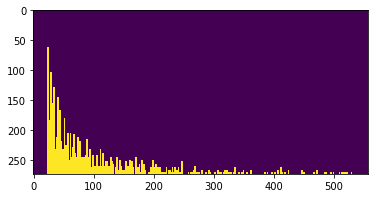

In [9]:
#color channel blue
plt.imshow(masque[1])

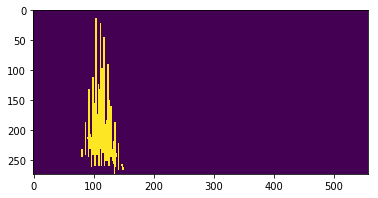

In [10]:
#color channel orange
plt.imshow(masque[2])

In [11]:
#create bgr channels
rendered1=cv2.merge([masque[1],masque[1],masque[1]])
rendered2=cv2.merge([masque[2],masque[2],masque[2]])

#convert hex to bgr color
blue=PIL.ImageColor.getcolor("#878f99", "RGB")[::-1]
orange=PIL.ImageColor.getcolor("#c1946a", "RGB")[::-1]

#save rendered images
cv2.imwrite('rendered1.png',np.where(rendered1==[0,0,0],[255,255,255],blue))
cv2.imwrite('rendered2.png',np.where(rendered2==[0,0,0],[255,255,255],orange))

True

In [12]:
#extract coordinates
erm=read_xy_from_pixels(masque[2],425,50,80,0,
                        56,origin=True,vert_flip=True)

df_er=clean_df_bar(erm)

bam=read_xy_from_pixels(masque[1],425,50,80,0,
                        56,origin=True,vert_flip=True)

df_ba=clean_df_bar(bam)

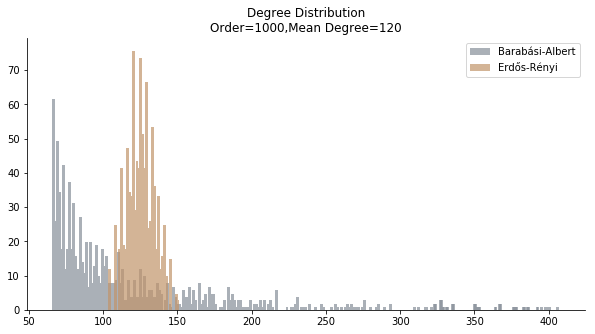

In [13]:
#reverse engineering
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(df_ba['x'],df_ba['y'],label='Barabási-Albert',color='#878f99',alpha=0.7)
plt.bar(df_er['x'],df_er['y'],label='Erdős-Rényi',color='#c1946a',alpha=0.7)
plt.legend(loc=0)
plt.title('Degree Distribution\nOrder=1000,Mean Degree=120')
plt.show()

In [14]:
img=cv2.imread('viz2.png',1)

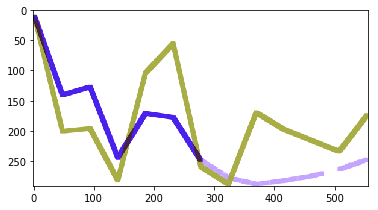

In [15]:
#connect dotted line via erosion
erosion=cv2.erode(img,np.ones((7,7),'uint8'),iterations=1)
cv2.imwrite("erosion1.png",erosion)

plt.imshow(erosion)

In [16]:
#use machine learning to separate color channels
masque=hsv_cluster(erosion,4,hsv_filter=False,save_img=True)

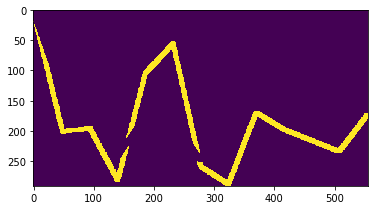

In [17]:
plt.imshow(masque[1])

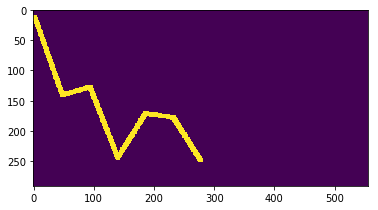

In [18]:
plt.imshow(masque[2])

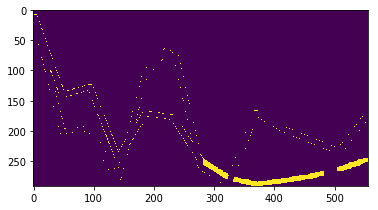

In [19]:
plt.imshow(masque[3])

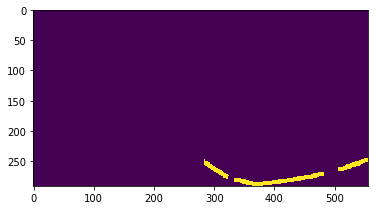

In [20]:
#use erosion to remove noise
erosion=cv2.erode(masque[3],np.ones((2,2),'uint8'),iterations=1)
cv2.imwrite("erosion2.png",erosion)

plt.imshow(erosion)

In [21]:
#extract coordinates
forecast=read_xy_from_pixels(erosion,2024,2012,200,100,
                        56,origin=True,vert_flip=True)

df_for=clean_df_line(forecast)

oilpalm=read_xy_from_pixels(masque[2],2024,2012,200,100,
                        56,origin=True,vert_flip=True)

df_op=clean_df_line(oilpalm)

palmoil=read_xy_from_pixels(masque[1],2024,2012,675,500,
                        56,origin=True,vert_flip=True)

df_po=clean_df_line(palmoil)

In [22]:
#convert to the axis scale
df_for=df_for[2::len(df_for)//6]
df_for.reset_index(inplace=True,drop=True)

In [23]:
#manually convert to the axis scale
df_op=df_op[1::len(df_op)//7]

df_op.reset_index(inplace=True,drop=True)

df_op.drop(3,inplace=True)

In [24]:
#convert to the axis scale
df_po=df_po[15::len(df_po)//13]
df_po.reset_index(inplace=True,drop=True)

In [25]:
#concatenate into one
output=pd.DataFrame()

output['x']=range(2012,2025)

output['y1']=df_po['y'].tolist()

output['y2']=df_op['y'].tolist()+df_for['y'].tolist()

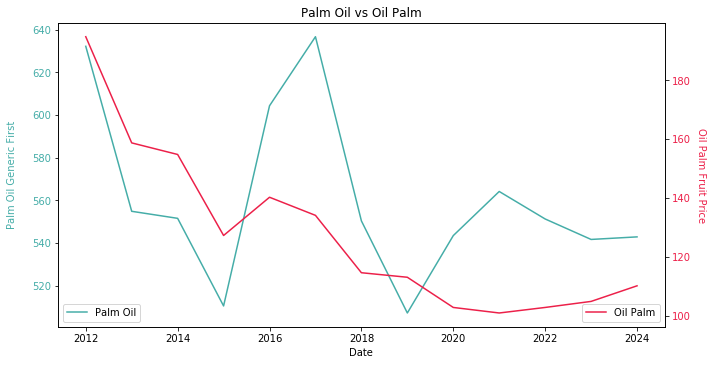

In [26]:
#reverse engineering
dual_axis_plot(output['x'],output['y1'],output['y2'],
               fst_color='#45ada8',sec_color='#ec2049',
               x_label='Date',y_label1='Palm Oil Generic First',
               y_label2='Oil Palm Fruit Price',
               legend1='Palm Oil',legend2='Oil Palm',
               title='Palm Oil vs Oil Palm')                   